# DSCI 617 – Project 01
## Analysis of NASA Server Logs
**Felix Asare**

## Part A: Set up Environment

Importing libraries for project

In [0]:
# Importing matplotlib, spark session
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

Creating SparkSession and SparkContext objects.

In [0]:
# Spark Session and spark context
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Part B: Load and Process Data


Loading Data for NASA server logs

In [0]:
# Loading NASA Data file
nasa_raw = sc.textFile("/FileStore/tables/NASA_server_logs_Aug_1995.txt")

# Printing number of element in file
nasa_raw.count()

1569888

Displaying the first few elements of the data

In [0]:
# Displaying first 10 rows
for row in nasa_raw.take(10):
    print(row)

in24.inetnebr.com [01/Aug/1995:00:00:01] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt" 200 1839
uplherc.upl.com [01/Aug/1995:00:00:07] "GET /" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/ksclogo-medium.gif" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/MOSAIC-logosmall.gif" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/USA-logosmall.gif" 304 0
ix-esc-ca2-07.ix.netcom.com [01/Aug/1995:00:00:09] "GET /images/launch-logo.gif" 200 1713
uplherc.upl.com [01/Aug/1995:00:00:10] "GET /images/WORLD-logosmall.gif" 304 0
slppp6.intermind.net [01/Aug/1995:00:00:10] "GET /history/skylab/skylab.html" 200 1687
piweba4y.prodigy.com [01/Aug/1995:00:00:10] "GET /images/launchmedium.gif" 200 11853
slppp6.intermind.net [01/Aug/1995:00:00:11] "GET /history/skylab/skylab-small.gif" 200 9202


Processing and tokenizing data

In [0]:
# Function to process row
def process_row(row):
    #Replacing double quotes with empty strings
    row = row.replace('"', '')

    #Tokenizing the string on space characters
    tokens = row.split()

    #Check if the last token (bytes) is a hyphen, replace it with 0
    if tokens[-1] == '-':
        tokens[-1] = '0'

    # Coercing the bytes token to an integer
    tokens[-1] = int(tokens[-1])

    # Returning the resulting list of tokens
    return tokens
  
# Applying the function to each row
nasa = nasa_raw.map(process_row)
nasa.persist()

for row in nasa.take(10):
    print(row)

['in24.inetnebr.com', '[01/Aug/1995:00:00:01]', 'GET', '/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', '200', 1839]
['uplherc.upl.com', '[01/Aug/1995:00:00:07]', 'GET', '/', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/ksclogo-medium.gif', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/MOSAIC-logosmall.gif', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/USA-logosmall.gif', '304', 0]
['ix-esc-ca2-07.ix.netcom.com', '[01/Aug/1995:00:00:09]', 'GET', '/images/launch-logo.gif', '200', 1713]
['uplherc.upl.com', '[01/Aug/1995:00:00:10]', 'GET', '/images/WORLD-logosmall.gif', '304', 0]
['slppp6.intermind.net', '[01/Aug/1995:00:00:10]', 'GET', '/history/skylab/skylab.html', '200', 1687]
['piweba4y.prodigy.com', '[01/Aug/1995:00:00:10]', 'GET', '/images/launchmedium.gif', '200', 11853]
['slppp6.intermind.net', '[01/Aug/1995:00:00:11]', 'GET', '/history/skylab/skylab-small.gif', '200', 9202]


## Part C: Most Requested Resources

Finding resources that was requested most

In [0]:
# Creating pair of rdd 
count_by_resource = (
    nasa.map(lambda row: (row[3], 1)) 
        .reduceByKey(lambda a, b: a + b) 
        .sortBy(lambda x: x[1], ascending=False)
)

# Printing the top 10 resources
for resource, count in count_by_resource.take(10):
    print(resource, count)

/images/NASA-logosmall.gif 97410
/images/KSC-logosmall.gif 75337
/images/MOSAIC-logosmall.gif 67448
/images/USA-logosmall.gif 67068
/images/WORLD-logosmall.gif 66444
/images/ksclogo-medium.gif 62778
/ksc.html 43688
/history/apollo/images/apollo-logo1.gif 37826
/images/launch-logo.gif 35138
/ 30347


## Part D: Most Common Request Origins

Finding the most common request origins


In [0]:
# Creating rdd pairs for server origin
count_by_origin = (
    nasa.map(lambda row: (row[0], 1))
        .reduceByKey(lambda a, b: a + b)
        .sortBy(lambda x: x[1], ascending=False)
)

# Printing the top 10 origins
for origin, count in count_by_origin.take(10):
    print(origin, count)

edams.ksc.nasa.gov 6530
piweba4y.prodigy.com 4846
163.206.89.4 4791
piweba5y.prodigy.com 4607
piweba3y.prodigy.com 4416
www-d1.proxy.aol.com 3889
www-b2.proxy.aol.com 3534
www-b3.proxy.aol.com 3463
www-c5.proxy.aol.com 3423
www-b5.proxy.aol.com 3411


## Part E: Request Types

Analying records based on request type

In [0]:
# Extracting the unique request types without using collect()
req_types = nasa.map(lambda row: row[2]).distinct()





Counting requests type


In [0]:
#Loop through the unique request types using RDD transformations
for req_type in req_types.collect():
    #determine the number of requests for each request type
    req_count = nasa.filter(lambda row: row[2] == req_type).count()
    #print the request type and count
    print(f'There were {req_count} {req_type} requests')



There were 1565812 GET requests
There were 3965 HEAD requests
There were 111 POST requests


Determining the average number of bytes returned to the client for each request type

In [0]:
# Create the avg_bytes RDD with the required transformations
avg_bytes = (
    nasa.filter(lambda row: len(row) > 5) 
    .map(lambda row: (row[2], (row[5], 1)))  
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    .mapValues(lambda x: round(x[0] / x[1])) 
)

# Print the results
for req_type, avg in avg_bytes.collect():
    print(f'The average bytes for {req_type} requests is {avg}')


The average bytes for GET requests is 17134
The average bytes for HEAD requests is 0
The average bytes for POST requests is 495


## Part F: Status Codes

Analyzing the status codes returned by the server.

In [0]:
# Getting distinct status code
status_codes = (
    nasa.filter(lambda row: len(row) > 4)
    .map(lambda row: row[4]) 
    .distinct() 
    .sortBy(lambda x: int(x)).collect()

)

# Print the sorted list of status codes
print(status_codes)

[0, '200', '302', '304', '403', '404', '500', '501']


Determining which status codes appear for each request

In [0]:
# Looping over the req_types list
for req_type in req_types.collect():
   
    status_codes_for_req_type = (
        nasa.filter(lambda row: len(row) > 4 and row[2] == req_type)
        .map(lambda row: row[4]) 
        .distinct()  
        .sortBy(lambda x: int(x))
        .collect()
    )

    # Step 6: Print the results
    print(f"The status codes for {req_type} requests: {status_codes_for_req_type}")


The status codes for GET requests: [0, '200', '302', '304', '403', '404', '500']
The status codes for HEAD requests: ['200', '302', '404']
The status codes for POST requests: ['200', '404', '501']


Counting the number of requests resulting in each status code and displaying results with bar chart

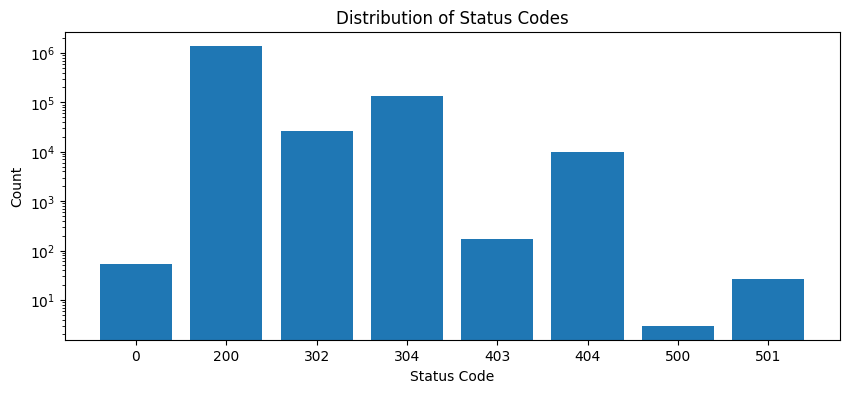

In [0]:
# Empty list
code_counts = []

for status_code in status_codes:
    # Determine the number of requests resulting in that particular status code
    count = nasa.filter(lambda row: len(row) > 4 and row[4] == status_code).count()
    
    # Append the resulting count to the code_counts list
    code_counts.append((str(status_code), str(count)))


status_codes = [code[0] for code in code_counts]
counts = [int(code[1]) for code in code_counts]

# Bar chart with status_codes and code_counts
plt.figure(figsize=(10, 4))
plt.bar(status_codes, counts)
plt.xlabel("Status Code")
plt.ylabel("Count")
plt.title("Distribution of Status Codes")
plt.yscale('log')
plt.show()


## Part G: Request Volume by Day

Counting requests received by day

In [0]:
counts_by_day = (
  nasa.map(lambda row: (row[1][1:3], 1))
    .reduceByKey(lambda a, b: a + b) 
    .sortByKey() 
    .collect()  
)

# Printing first 5  
print(counts_by_day[:5])

[('01', 33996), ('03', 41388), ('04', 59557), ('05', 31893), ('06', 32420)]


Displaying the distribution of requests by day of the month

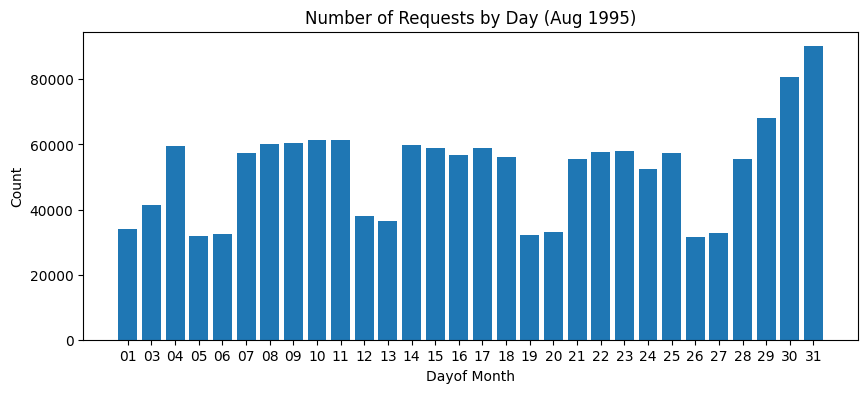

In [0]:
# Seperating tuple in count_by_day
day_list = []
count_list = []

# Loop over each tuple in the list
for day, count in counts_by_day:
    day_list.append(day)
    count_list.append(count)

# Plotting bar chart
plt.figure(figsize=(10, 4))
plt.bar(day_list, count_list)
plt.xlabel("Dayof Month")
plt.ylabel("Count")
plt.title("Number of Requests by Day (Aug 1995)")
plt.show()